In [220]:
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from utilities_project import MySQL_login
mysql, engine = MySQL_login()

/Users/patriciagoresen/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:279: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


In [180]:
# Import data set
movies = pd.read_sql('SELECT * FROM movie_data', con=mysql).set_index("title")

In [181]:
# Look at data 
movies.head()

,title,vote_average,cast1,cast2,cast3,producer1,producer2,producer3,original_language1,vote_count,...,director3,revenue,genres1,genres2,genres3,release_date,production_countries1,production_countries2,writer1,runtimes
0,Four Rooms,6.6,1.0,1.0,1.0,1.0,1.0,1.0,en,714,...,4.0,4300000,Crime,Comedy,NaN,['1995-12-09'],United States of America,NaN,2.0,98.0
1,Judgment Night,6.4,1.0,1.0,1.0,1.0,1.0,1.0,en,96,...,NaN,12,Action,Thriller,Crime,['1993-10-15'],Japan,United States of America,2.0,110.0
2,Star Wars,8.1,1.0,1.0,1.0,1.0,1.0,1.0,en,8550,...,NaN,775398007,Adventure,Action,Science Fiction,['1977-05-25'],United States of America,NaN,31.0,121.0
3,Finding Nemo,7.7,1.0,1.0,1.0,1.0,2.0,1.0,en,8085,...,NaN,940335536,Animation,Family,NaN,['2003-05-30'],United States of America,NaN,6.0,100.0
4,Forrest Gump,8.3,1.0,1.0,1.0,1.0,1.0,1.0,en,10346,...,NaN,677945399,Comedy,Drama,Romance,['1994-07-06'],United States of America,NaN,1.0,142.0


In [182]:
# Look at number of observations
len(movies)

8462

In [228]:
# See columns with highly missing data
print(movies.isnull().sum())

title                      0
vote_average               0
cast1                      0
cast2                      0
cast3                      5
producer1                 13
producer2                171
producer3                483
original_language1         0
vote_count                 0
production_companies1      0
production_companies2    980
director1                  0
revenue                    0
genres1                    0
genres2                  583
production_countries1      0
writer1                   26
runtimes                  13
year                       0
month                      0
dtype: int64


In [229]:
# delete columns with highly missing values
movies.drop(['director2'], axis = 1, inplace = True)
movies.drop(['director3'], axis = 1, inplace = True)
movies.drop(['production_companies3'], axis = 1, inplace = True)
movies.drop(['genres3'], axis = 1, inplace = True)
movies.drop(['production_countries2'], axis = 1, inplace = True)

ValueError: labels ['director2'] not contained in axis

In [185]:
# delete observations with unreasonable revenue values
movies = movies[movies.revenue >= 1000]

In [186]:
# Look at data again
movies.head()
len(movies)

3507

In [187]:
# Split up release_date into month and year
movies[['year', 'month', 'day']] = movies['release_date'].str.split('-', expand=True)
movies['year'] = movies['year'].str[2:]
movies.drop(['day'], axis = 1, inplace = True)
movies.drop(['release_date'], axis = 1, inplace = True)

In [188]:
# Look at result
movies.head()

,title,vote_average,cast1,cast2,cast3,producer1,producer2,producer3,original_language1,vote_count,...,production_companies2,director1,revenue,genres1,genres2,production_countries1,writer1,runtimes,year,month
0,Four Rooms,6.6,1.0,1.0,1.0,1.0,1.0,1.0,en,714,...,1.0,1.0,4300000,Crime,Comedy,United States of America,2.0,98.0,1995,12
2,Star Wars,8.1,1.0,1.0,1.0,1.0,1.0,1.0,en,8550,...,1.0,25.0,775398007,Adventure,Action,United States of America,31.0,121.0,1977,05
3,Finding Nemo,7.7,1.0,1.0,1.0,1.0,2.0,1.0,en,8085,...,NaN,2.0,940335536,Animation,Family,United States of America,6.0,100.0,2003,05
4,Forrest Gump,8.3,1.0,1.0,1.0,1.0,1.0,1.0,en,10346,...,NaN,2.0,677945399,Comedy,Drama,United States of America,1.0,142.0,1994,07
5,American Beauty,8.0,1.0,1.0,1.0,1.0,1.0,1.0,en,4571,...,1.0,1.0,356296601,Drama,NaN,United States of America,2.0,122.0,1999,09


In [189]:
# see if we have any other highly missing columns
print(movies.isnull().sum())

title                      0
vote_average               0
cast1                      0
cast2                      0
cast3                      5
producer1                 13
producer2                171
producer3                483
original_language1         0
vote_count                 0
production_companies1      0
production_companies2    980
director1                  0
revenue                    0
genres1                    0
genres2                  583
production_countries1      0
writer1                   26
runtimes                  13
year                       0
month                      0
dtype: int64


In [190]:
# In order to do random forest we need to create dummy variables for categorical data
genres1_dmy = pd.get_dummies(movies['genres1'], drop_first=True)
genres2_dmy = pd.get_dummies(movies['genres2'], drop_first=True)
origlang_dmy = pd.get_dummies(movies['original_language1'], drop_first=True)
prodcomp_dmy = pd.get_dummies(movies['production_countries1'], drop_first=True)

In [191]:
# Concatenate dummy variables to data set 
movies2 = pd.concat([movies,genres1_dmy,genres2_dmy,prodcomp_dmy,origlang_dmy ], axis = 1 )

In [192]:
# Drop variables we dont want in RF model
movies2 = movies2.drop(['title', 'genres1','genres2','production_countries1', 'original_language1' ], axis = 1)

In [193]:
#Change year and  day to numeric
movies2['year'] = pd.to_numeric(movies2['year'], errors='coerce')
movies2['month'] = pd.to_numeric(movies2['month'], errors='coerce')

In [194]:
# Drop Nan values
movies2 = movies2.dropna()

In [195]:
# Check Data Types
movies2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2274 entries, 0 to 8436
Columns: 103 entries, vote_average to zh
dtypes: float64(12), int64(4), uint8(87)
memory usage: 495.2 KB


In [196]:
# Change columns all floats to int besides vote_average and runtimes
movies2.loc[:, movies2.dtypes == float]
movies2[['cast1','cast2', 'cast3' , 'producer1' , 'producer2' , 'producer3' , 'production_companies1', 'production_companies2' , 'director1', 'writer1']] = movies2[['cast1','cast2', 'cast3' , 'producer1' , 'producer2' , 'producer3' , 'production_companies1', 'production_companies2' , 'director1', 'writer1']].round(0).astype(int)

In [197]:
# Make sure only vote_average and runtimes are floats
movies2.info()
movies2.loc[:, movies2.dtypes == float]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2274 entries, 0 to 8436
Columns: 103 entries, vote_average to zh
dtypes: float64(2), int64(14), uint8(87)
memory usage: 495.2 KB


,vote_average,runtimes
0,6.6,98.0
2,8.1,121.0
5,8.0,122.0
7,7.7,140.0
9,7.6,143.0
10,7.8,111.0
11,6.6,125.0
12,8.1,147.0
13,7.8,130.0
14,6.9,87.0


In [230]:
# Split into x and y for prediction
X = movies2.drop(['revenue', 'logrevenue'], axis = 1)
Y = movies2['revenue']
movies2['logrevenue'] = round(np.log(movies2.revenue), 2)
YLog = movies2['logrevenue']
movies2.head()

,vote_average,cast1,cast2,cast3,producer1,producer2,producer3,vote_count,production_companies1,production_companies2,...,en,es,fr,hi,it,ja,pt,uk,zh,logrevenue
0,6.6,1,1,1,1,1,1,714,1,1,...,1,0,0,0,0,0,0,0,0,15.27
2,8.1,1,1,1,1,1,1,8550,1,1,...,1,0,0,0,0,0,0,0,0,20.47
5,8.0,1,1,1,1,1,1,4571,1,1,...,1,0,0,0,0,0,0,0,0,19.69
7,7.7,1,1,1,1,1,1,512,1,1,...,1,0,0,0,0,0,0,0,0,17.51
9,7.6,1,1,1,2,1,1,8950,1,1,...,1,0,0,0,0,0,0,0,0,20.30


In [231]:
# Separate into test and training sets
#X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=101)
X_train, X_test, log_train, log_test = train_test_split(X, YLog, test_size=0.3, random_state=101)

In [232]:
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(log_train)
y_test = np.array(log_test)

In [210]:
#### RANDOM FOREST MODEL ####

In [211]:
# First model
rf = RandomForestRegressor(criterion='mse')
RFmodel1 = rf.fit(X_train, y_train)

In [212]:
# Predict 
RFmodelPred1 = RFmodel1.predict(X_test)

In [156]:
# MSE
RF1meanSquaredError = mean_squared_error(y_test, RFmodelPred1)
print("MSE:", RF1meanSquaredError)
r2_score(y_test, RFmodelPredlog)

In [233]:
#Random Forest model 2
RFmodel2 = rf.fit(X_train, y_train)
RFmodelPredlog = RFmodel2.predict(X_test)
#MSE and R2
RFlogmeanSquaredError = mean_squared_error(y_test, RFmodelPredlog)
print("MSE:", RFlogmeanSquaredError)
r2_score(logtest, RFmodelPredlog)

MSE: 1.46245350659


0.62191126116734297

Feature ranking:
1. feature 7 (0.567953)
2. feature 13 (0.069995)
3. feature 12 (0.058987)
4. feature 0 (0.047237)
5. feature 9 (0.037809)
6. feature 4 (0.018191)
7. feature 14 (0.017824)
8. feature 1 (0.016692)
9. feature 11 (0.016475)
10. feature 8 (0.016115)
11. feature 6 (0.014432)
12. feature 2 (0.013026)
13. feature 5 (0.012492)
14. feature 10 (0.011063)
15. feature 3 (0.010639)
16. feature 42 (0.005085)
17. feature 38 (0.004121)
18. feature 15 (0.004026)
19. feature 57 (0.003782)
20. feature 24 (0.003494)
21. feature 91 (0.003476)
22. feature 93 (0.003438)
23. feature 44 (0.003172)
24. feature 20 (0.003042)
25. feature 47 (0.002771)
26. feature 35 (0.002472)
27. feature 46 (0.002130)
28. feature 90 (0.002051)
29. feature 17 (0.001975)
30. feature 30 (0.001969)
31. feature 33 (0.001763)
32. feature 16 (0.001748)
33. feature 39 (0.001702)
34. feature 36 (0.001608)
35. feature 26 (0.001601)
36. feature 43 (0.001586)
37. feature 63 (0.001391)
38. feature 28 (0.001366)
39. feature 22

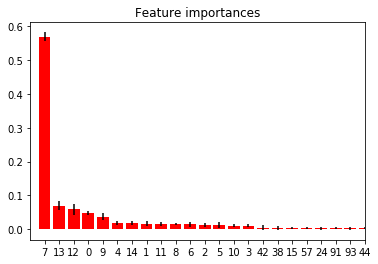

In [239]:
importances = RFmodel2.feature_importances_
std = np.std([tree.feature_importances_ for tree in RFmodel2.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
print("Feature ranking:")
for f in range(X_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))
# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), indices)
plt.xlim([-1, X_train.shape[1]-80])
plt.show()


In [242]:
list(movies2)

['vote_average',
 'cast1',
 'cast2',
 'cast3',
 'producer1',
 'producer2',
 'producer3',
 'vote_count',
 'production_companies1',
 'production_companies2',
 'director1',
 'revenue',
 'writer1',
 'runtimes',
 'year',
 'month',
 'Adventure',
 'Animation',
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Family',
 'Fantasy',
 'History',
 'Horror',
 'Music',
 'Mystery',
 'Romance',
 'Science Fiction',
 'TV Movie',
 'Thriller',
 'War',
 'Western',
 'Adventure',
 'Animation',
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Family',
 'Fantasy',
 'History',
 'Horror',
 'Music',
 'Mystery',
 'Romance',
 'Science Fiction',
 'Thriller',
 'War',
 'Western',
 'Australia',
 'Austria',
 'Bahamas',
 'Belgium',
 'Brazil',
 'Bulgaria',
 'Cambodia',
 'Canada',
 'China',
 'Czech Republic',
 'Denmark',
 'Finland',
 'France',
 'Germany',
 'Greece',
 'Hong Kong',
 'Iceland',
 'India',
 'Ireland',
 'Israel',
 'Italy',
 'Japan',
 'Luxembourg',
 'Mexico',
 'Namibia',
 'Netherlands',
 'New Zealand',
 'Peru',
 '